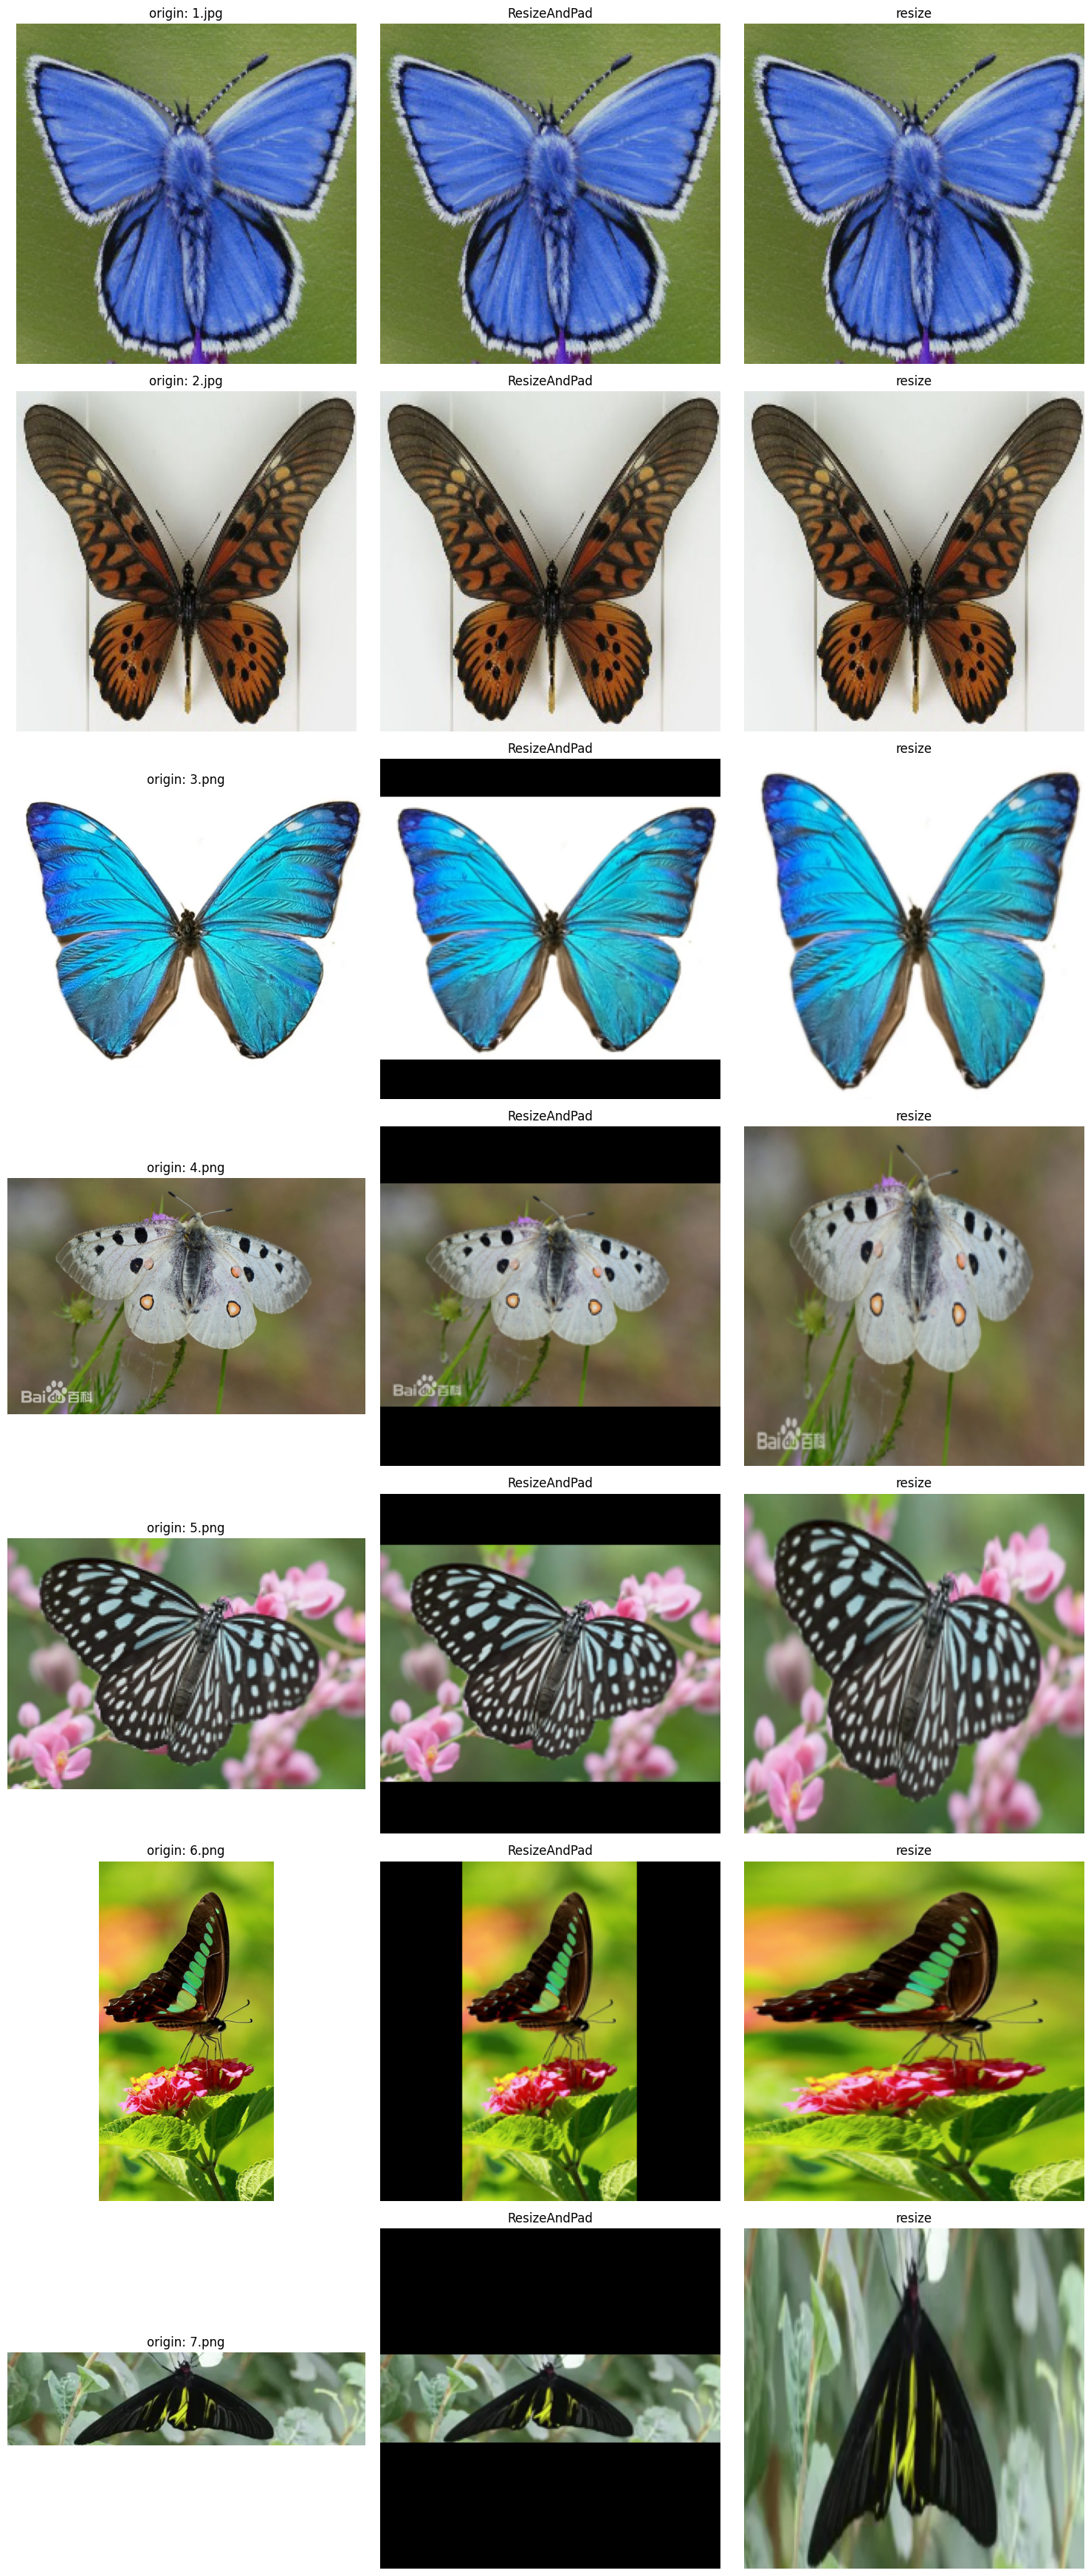

In [3]:
# 导入必要的库
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
import torchvision.transforms.functional as TF

# 定义自定义的ResizeAndPad类
class ResizeAndPad:
    def __init__(self, size, fill=0):
        """
        初始化ResizeAndPad类
        Args:
            size (tuple or int): 期望的输出大小。如果是元组，则输出大小将匹配此大小。如果是整数，则较小的边将匹配此大小。
            fill (int or tuple): 填充的像素值。默认值为0
        """
        if isinstance(size, int):
            self.size = (size, size)
        else:
            self.size = size
        self.fill = fill

    def __call__(self, img):
        # 获取当前和期望的宽高比
        original_size = img.size  # (宽, 高)
        ratio = min(self.size[0] / original_size[0], self.size[1] / original_size[1])
        new_size = (int(original_size[0] * ratio), int(original_size[1] * ratio))
        img = img.resize(new_size, Image.BICUBIC)  # 使用双三次插值调整大小

        # 创建一个新的图像并粘贴调整大小后的图像
        new_img = Image.new("RGB", self.size, (self.fill, self.fill, self.fill))
        paste_position = ((self.size[0] - new_size[0]) // 2,
                          (self.size[1] - new_size[1]) // 2)
        new_img.paste(img, paste_position)
        return new_img
    
# 直接Resize
data_transforms = transforms.Compose([
                        transforms.Resize((224, 224)),       # 调整大小到224x224
                        transforms.ToTensor(),               # 转换为张量
                        transforms.Normalize([0.485, 0.456, 0.406],  # 归一化
                                             [0.229, 0.224, 0.225])
                    ])


# 定义一个函数来反归一化图像，用于显示
def unnormalize(tensor, mean, std):
    """
    反归一化张量
    Args:
        tensor (Tensor): 归一化后的张量
        mean (list): 均值
        std (list): 标准差
    Returns:
        Tensor: 反归一化后的张量
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# 设置图片文件夹路径
original_img_dir = 'images/test_images_predict'  # 原始图片文件夹

# 获取原始图片文件夹中的所有图片文件
img_files = [f for f in os.listdir(original_img_dir) 
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# 选择前几张图片进行处理和展示（例如前4张）
num_images = min(10, len(img_files))
selected_imgs = img_files[:num_images]

# 设置绘图的行数和列数（每张图片3列：原始、ResizeAndPad处理）
fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
if num_images == 1:
    axes = [axes]  # 确保axes是列表

# 定义ResizeAndPad转换
resize_pad_transform = ResizeAndPad((224, 224), fill=0)

for idx, img_name in enumerate(selected_imgs):
    img_path = os.path.join(original_img_dir, img_name)
    img = Image.open(img_path).convert('RGB')  # 打开并转换为RGB

    # 显示原始图像
    axes[idx][0].imshow(img)
    axes[idx][0].set_title(f'origin: {img_name}')
    axes[idx][0].axis('off')

    # 使用ResizeAndPad进行处理
    resized_padded_img = resize_pad_transform(img)
    # 显示ResizeAndPad处理后的图像
    axes[idx][1].imshow(resized_padded_img)
    axes[idx][1].set_title('ResizeAndPad')
    axes[idx][1].axis('off')
    
    # 使用data_transforms进行处理
    transformed_tensor_valid = data_transforms(img)
    # 反归一化以便显示
    unnorm_tensor_valid = unnormalize(transformed_tensor_valid.clone(),
                                 mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    # 转换为numpy数组并限制范围在[0,1]
    unnorm_img_valid = TF.to_pil_image(torch.clamp(unnorm_tensor_valid, 0, 1))
    # 显示data_transforms处理后的图像
    axes[idx][2].imshow(unnorm_img_valid)
    axes[idx][2].set_title('resize')
    axes[idx][2].axis('off')

plt.tight_layout()
plt.show()